In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import confusion_matrix
import graphviz
from sklearn import tree

C:\Users\mpfou\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mpfou\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Reading Data

In [2]:
train_data=pd.read_csv('data_train.csv')
test_data=pd.read_csv('data_test.csv')
print(train_data.head())

   emotion   p1   p2   p3   p4   p5   p6   p7   p8   p9  ...    p2295  p2296  \
0        0   70   80   82   72   58   58   60   63   54  ...      159    182   
1        0  151  150  147  155  148  133  111  140  170  ...      105    108   
2        2  231  212  156  164  174  138  161  173  182  ...      104    138   
3        4   24   32   36   30   32   23   19   20   30  ...      174    126   
4        6    4    0    0    0    0    0    0    0    0  ...       12     34   

   p2297  p2298  p2299  p2300  p2301  p2302  p2303  p2304  
0    183    136    106    116     95    106    109     82  
1     95    108    102     67    171    193    183    184  
2    152    122    114    101     97     88    110    152  
3    132    132    133    136    139    142    143    142  
4     31     31     31     27     31     30     29     30  

[5 rows x 2305 columns]


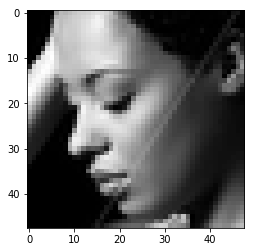

Emotion is Fear
2


In [4]:
#Showing images in the training dataset
index=129
img=np.array(train_data.loc[index,'p1':'p2304']).reshape(48,48)
plt.imshow(img,cmap='gray')
plt.show()
print('Emotion is Fear')
print(train_data['emotion'][129])

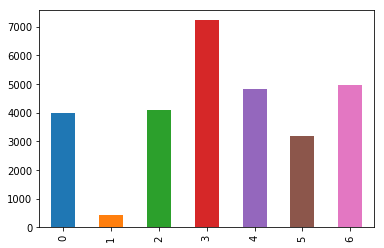

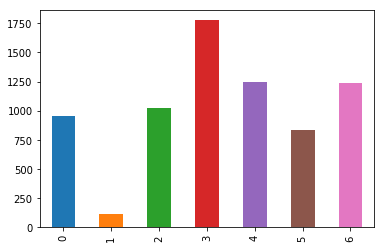

In [5]:
train_data['emotion'].value_counts().sort_index().plot.bar()
plt.show()
test_data['emotion'].value_counts().sort_index().plot.bar()
plt.show()

In [51]:
print(train_data['emotion'].value_counts().sort_index()/train_data.shape[0])
print(test_data['emotion'].value_counts().sort_index()/test_data.shape[0])

0    0.139155
1    0.015187
2    0.142708
3    0.251315
4    0.168240
5    0.110453
6    0.172942
Name: emotion, dtype: float64
0    0.133463
1    0.015464
2    0.142658
3    0.247144
4    0.173725
5    0.115770
6    0.171775
Name: emotion, dtype: float64


In [3]:
#Randomizing the dataset
np.random.seed(1)
shuffled_index=np.random.permutation(train_data.index)
final_data_train=train_data.loc[shuffled_index]
print(final_data_train.head())

       emotion   p1   p2   p3   p4   p5   p6   p7   p8   p9  ...    p2295  \
1239         0   70   80   82   72   58   58   60   63   54  ...      159   
6674         0  151  150  147  155  148  133  111  140  170  ...      105   
11209        2  231  212  156  164  174  138  161  173  182  ...      104   
21998        4   24   32   36   30   32   23   19   20   30  ...      174   
20847        6    4    0    0    0    0    0    0    0    0  ...       12   

       p2296  p2297  p2298  p2299  p2300  p2301  p2302  p2303  p2304  
1239     182    183    136    106    116     95    106    109     82  
6674     108     95    108    102     67    171    193    183    184  
11209    138    152    122    114    101     97     88    110    152  
21998    126    132    132    133    136    139    142    143    142  
20847     34     31     31     31     27     31     30     29     30  

[5 rows x 2305 columns]


In [4]:
#Feature extraction
normalized_pixels=final_data_train.loc[:,'p1':'p2304']/255
sorted_var=normalized_pixels.var().sort_values(ascending=False)
greater_var=sorted_var[sorted_var>0.06]
extracted_features=greater_var.index.tolist()
print(len(extracted_features))
print(final_data_train[extracted_features].head())

1042
        p1  p48  p49  p96  p97  p144   p2  p145  p192  p47  ...    p175  \
1239    70   41   65   44   50    47   80    38    45   43  ...     196   
6674   151  120  151  137  151   146  150   151   139  140  ...     146   
11209  231   16  229   27  214    28  212   202    23   27  ...     231   
21998   24  173   25  173   26   174   32    26   174  172  ...      51   
20847    4   25    1   26    0    26    0     0    28   24  ...     183   

       p2100  p712  p567  p225  p2078  p2289  p395  p254  p1016  
1239      76    53    38   200    118    173   153   170    177  
6674     132    73   118   140    120    133   125   158    135  
11209     98   196   194   228    235    130   184   188    228  
21998    164   188   194    71    155    114    33    22    154  
20847    158   169   199   190     53    155    81   108     98  

[5 rows x 1042 columns]


In [5]:
#Getting feature and target columns
X_train=final_data_train.loc[:,'p1':'p2304']
y_train=final_data_train['emotion']
X_test=test_data.loc[:,'p1':'p2304']
y_test=test_data['emotion']


In [54]:
print(X_train.shape)
print(X_test.shape)

(28709, 2304)
(7178, 2304)


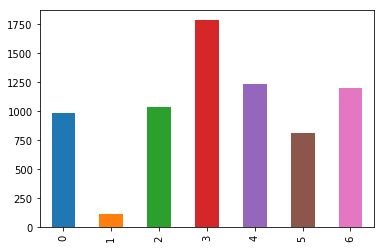

In [10]:
#Non uniform distribution of 'emotion' column in test dataset
y_test.value_counts().sort_index().plot.bar()
plt.show()

In [11]:
#Showing emotion column distribution in test set
print(y_test.value_counts().sort_index())
print(y_test.value_counts().sort_index()/y_test.shape[0])

0     987
1     119
2    1040
3    1785
4    1233
5     810
6    1204
Name: emotion, dtype: int64
0    0.137503
1    0.016578
2    0.144887
3    0.248677
4    0.171775
5    0.112845
6    0.167735
Name: emotion, dtype: float64


## Reading Happy dataset

In [6]:
train_data_happy=pd.read_csv('training_happy_data.csv')
test_data_happy=pd.read_csv('testing_happy_data.csv')
print(train_data_happy.head())

    p1   p2   p3   p4   p5   p6   p7   p8   p9  p10    ...     p2296  p2297  \
0   70   80   82   72   58   58   60   63   54   58    ...       182    183   
1  151  150  147  155  148  133  111  140  170  174    ...       108     95   
2  231  212  156  164  174  138  161  173  182  200    ...       138    152   
3   24   32   36   30   32   23   19   20   30   41    ...       126    132   
4    4    0    0    0    0    0    0    0    0    0    ...        34     31   

   p2298  p2299  p2300  p2301  p2302  p2303  p2304   emotion  
0    136    106    116     95    106    109     82  NotHappy  
1    108    102     67    171    193    183    184  NotHappy  
2    122    114    101     97     88    110    152  NotHappy  
3    132    133    136    139    142    143    142  NotHappy  
4     31     31     27     31     30     29     30  NotHappy  

[5 rows x 2305 columns]


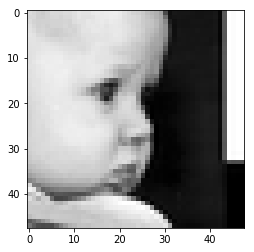

NotHappy


In [58]:
#Showing images in the dataset
index=12
img=np.array(train_data_happy.loc[index,'p1':'p2304']).reshape(48,48)
plt.imshow(img,cmap='gray')
plt.show()
print(train_data_happy['emotion'][12])

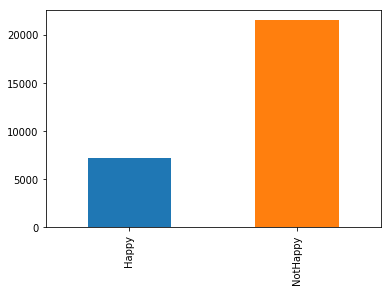

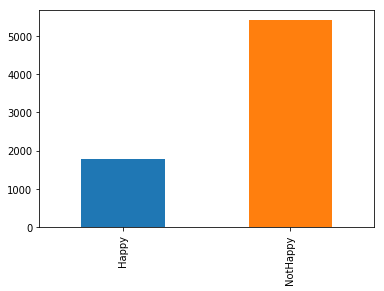

In [59]:
train_data_happy['emotion'].value_counts().sort_index().plot.bar()
plt.show()
test_data_happy['emotion'].value_counts().sort_index().plot.bar()
plt.show()

In [60]:
print(train_data_happy['emotion'].value_counts().sort_index()/train_data_happy.shape[0])
print(test_data_happy['emotion'].value_counts().sort_index()/test_data_happy.shape[0])

Happy       0.251315
NotHappy    0.748685
Name: emotion, dtype: float64
Happy       0.247144
NotHappy    0.752856
Name: emotion, dtype: float64


In [7]:
#Randomizing the dataset
np.random.seed(1)
shuffled_index=np.random.permutation(train_data_happy.index)
train_data_happy=train_data_happy.loc[shuffled_index]
print(train_data_happy.head())

        p1   p2   p3   p4   p5   p6   p7   p8   p9  p10    ...     p2296  \
1239    70   80   82   72   58   58   60   63   54   58    ...       182   
6674   151  150  147  155  148  133  111  140  170  174    ...       108   
11209  231  212  156  164  174  138  161  173  182  200    ...       138   
21998   24   32   36   30   32   23   19   20   30   41    ...       126   
20847    4    0    0    0    0    0    0    0    0    0    ...        34   

       p2297  p2298  p2299  p2300  p2301  p2302  p2303  p2304   emotion  
1239     183    136    106    116     95    106    109     82  NotHappy  
6674      95    108    102     67    171    193    183    184  NotHappy  
11209    152    122    114    101     97     88    110    152  NotHappy  
21998    132    132    133    136    139    142    143    142  NotHappy  
20847     31     31     31     27     31     30     29     30  NotHappy  

[5 rows x 2305 columns]


In [8]:
#Splitting final_data_happy into train and test set
X_train_happy=train_data_happy.loc[:,'p1':'p2304']
y_train_happy=train_data_happy['emotion']
X_test_happy=test_data_happy.loc[:,'p1':'p2304']
y_test_happy=test_data_happy['emotion']

In [63]:
print(X_train_happy.shape)
print(X_test_happy.shape)

(28709, 2304)
(7178, 2304)


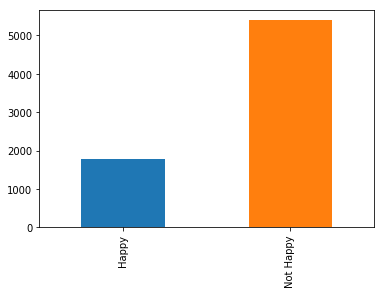

In [40]:
#Non uniform distribution of 'emotion' column in happy test dataset
y_test_happy.value_counts().sort_index().plot.bar()
plt.show()

In [64]:
#Showing emotion column distribution in test set
print(y_test_happy.value_counts().sort_index())
print(y_test_happy.value_counts().sort_index()/y_test_happy.shape[0])

Happy       1774
NotHappy    5404
Name: emotion, dtype: int64
Happy       0.247144
NotHappy    0.752856
Name: emotion, dtype: float64


## Function for decision tree

In [8]:
def run_decision_tree(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    train_predictions=clf.predict(X_train)
    test_predictions=clf.predict(X_test)
    train_accuracy=accuracy_score(y_train,train_predictions)
    test_accuracy=accuracy_score(y_test,test_predictions)
    c_matrix=confusion_matrix(test_predictions,y_test)
    ax=plt.subplot()
    cm=pd.DataFrame(c_matrix)
    
    #Finding the relative percent of actual vs prediction
    row_sum=cm.sum(axis=0)
    cm=cm.apply(lambda x:x/row_sum,axis=1)
    sns.heatmap(cm,annot=True,ax=ax)
    ax.set_xlabel('True labels')
    ax.set_ylabel('Predicted labels')
    plt.show()
    test_predictions=pd.DataFrame(test_predictions)
    test_predictions[0].value_counts().sort_index().plot.bar()
    plt.show()
    print("Accuracy on training set :",train_accuracy)
    print("Accuracy on testing set :",test_accuracy)
    
    

## Running Decision tree with different settings on multiclass dataset

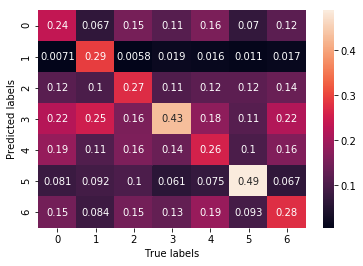

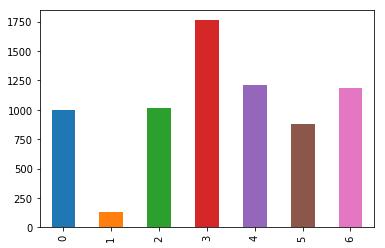

Accuracy on training set : 0.9984673795673831
Accuracy on testing set : 0.3310114237949289


In [83]:
#Decision tree on multiclass main dataset,without cross validation
clf=DecisionTreeClassifier(random_state=1)
run_decision_tree(clf,X_train,y_train,X_test,y_test)

In [84]:
#KFold cross validation accuracy results on training set with default Decision Tree
#Performing 10 Fold Cross Validation with 10 folds

clf=DecisionTreeClassifier(random_state=1)
accuracy=cross_val_score(clf,X_train,y_train,cv=10,scoring='accuracy')
print(accuracy)

[0.29913043 0.31106472 0.30351549 0.30734424 0.31219512 0.31637631
 0.30742419 0.31195539 0.32217573 0.30195258]


In [85]:
print("Accuracy Using KFold Cross Validation is:",accuracy.mean())

Accuracy Using KFold Cross Validation is: 0.30931341972012216


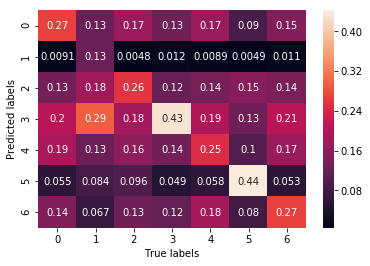

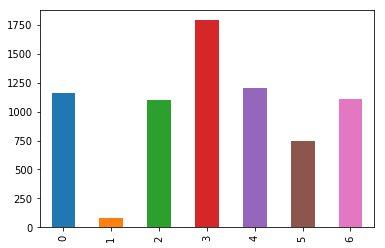

Accuracy on training set : 0.8155630638475739
Accuracy on testing set : 0.32014488715519646


In [86]:
#Experimenting with different parameters to fix overfitting
clf=DecisionTreeClassifier(random_state=1,min_samples_split=13)
run_decision_tree(clf,X_train,y_train,X_test,y_test)

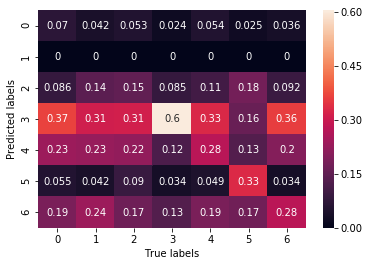

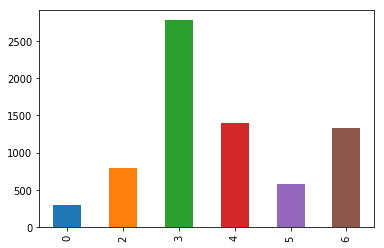

Accuracy on training set : 0.36065345362081574
Accuracy on testing set : 0.31303984396767903


In [87]:
#Experimenting with different parameters 
clf=DecisionTreeClassifier(random_state=1,min_samples_split=13,max_depth=7)
run_decision_tree(clf,X_train,y_train,X_test,y_test)

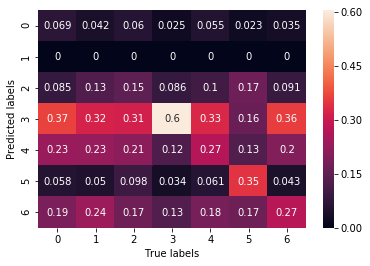

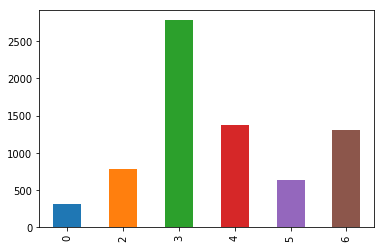

Accuracy on training set : 0.3536173325438016
Accuracy on testing set : 0.3117860128169406


In [88]:
#Experimenting with different parameters 
clf=DecisionTreeClassifier(random_state=1,min_samples_split=150,max_depth=7)
run_decision_tree(clf,X_train,y_train,X_test,y_test)

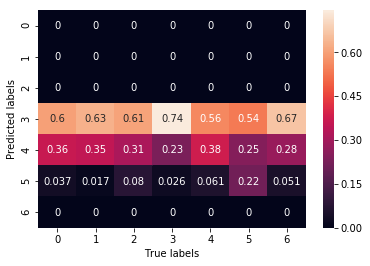

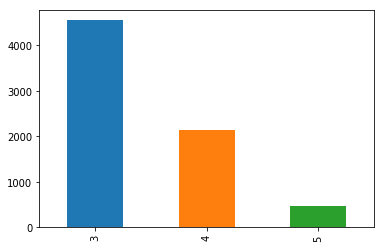

Accuracy on training set : 0.27402556689539864
Accuracy on testing set : 0.2743103928670939


In [89]:
#Experimenting with different parameters
clf=DecisionTreeClassifier(random_state=1,min_samples_split=100,max_depth=2)
run_decision_tree(clf,X_train,y_train,X_test,y_test)

## Moving 9000 rows

In [9]:
#Moving 9000 rows from training to testing in main multiclass datasets
pixel_cols=final_data_train.columns.drop('emotion')
rows_9000=final_data_train.iloc[:9000]
print(rows_9000.shape)
X_train_9=final_data_train.iloc[9000:][pixel_cols]
y_train_9=final_data_train.iloc[9000:]['emotion']
print(X_train_9.shape)
new_test=pd.concat((test_data,rows_9000),axis=0)
X_test_9=new_test[pixel_cols]
y_test_9=new_test['emotion']
print(X_test_9.shape)

(9000, 2305)
(19709, 2304)
(16178, 2304)


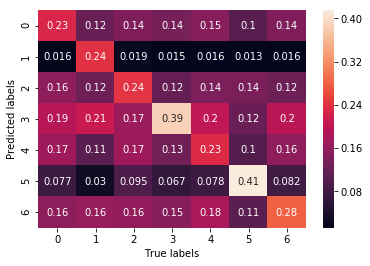

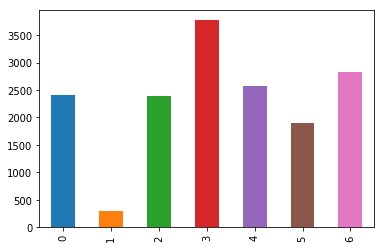

Accuracy on training set : 0.9988330204475113
Accuracy on testing set : 0.30220051922363705


In [47]:
clf_9=DecisionTreeClassifier(random_state=1)
run_decision_tree(clf_9,X_train_9,y_train_9,X_test_9,y_test_9)

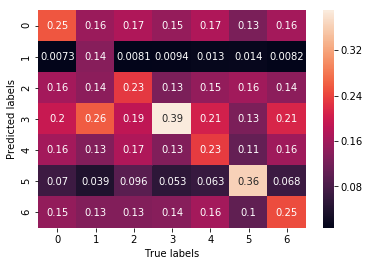

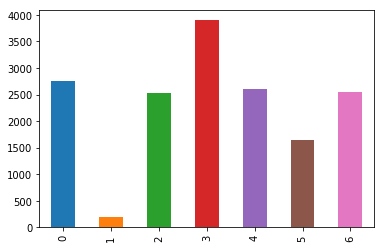

Accuracy on training set : 0.8098330711857527
Accuracy on testing set : 0.2914451724564223


In [48]:
clf_9=DecisionTreeClassifier(random_state=1,min_samples_split=13)
run_decision_tree(clf_9,X_train_9,y_train_9,X_test_9,y_test_9)

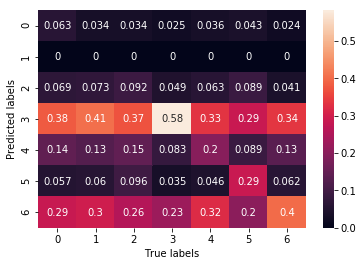

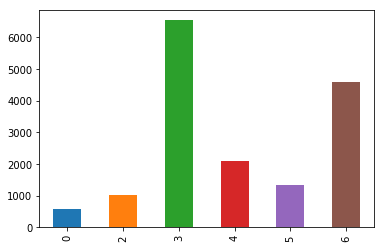

Accuracy on training set : 0.36612715003297985
Accuracy on testing set : 0.3044257633823711


In [49]:
clf_9=DecisionTreeClassifier(random_state=1,min_samples_split=13,max_depth=7)
run_decision_tree(clf_9,X_train_9,y_train_9,X_test_9,y_test_9)

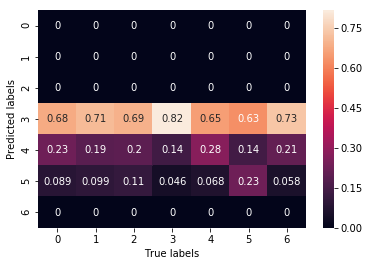

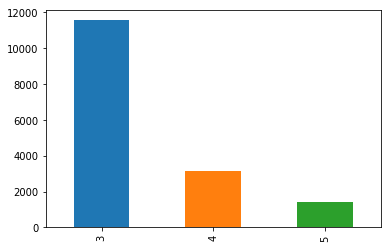

Accuracy on training set : 0.28073468973565374
Accuracy on testing set : 0.2795772036098405


In [50]:
clf_9=DecisionTreeClassifier(random_state=1,min_samples_split=100,max_depth=2)
run_decision_tree(clf_9,X_train_9,y_train_9,X_test_9,y_test_9)

## Moving 16000 rows

In [10]:
#Moving 16000 rows from training to testing in main multiclass datasets
pixel_cols=final_data_train.columns.drop('emotion')
rows_16000=final_data_train.iloc[:16000]
print(rows_16000.shape)
X_train_16=final_data_train.iloc[16000:][pixel_cols]
y_train_16=final_data_train.iloc[16000:]['emotion']
print(X_train_16.shape)
new_test=pd.concat((test_data,rows_16000),axis=0)
X_test_16=new_test[pixel_cols]
y_test_16=new_test['emotion']
print(X_test_16.shape)

(16000, 2305)
(12709, 2304)
(23178, 2304)


In [52]:
X_train_16.shape

(12709, 2304)

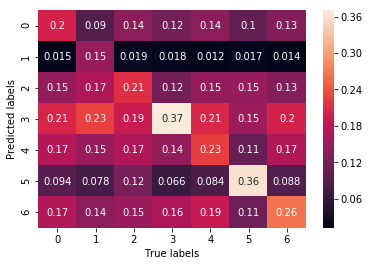

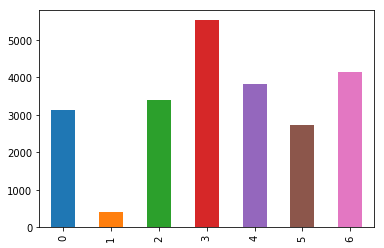

Accuracy on training set : 0.9991344716342749
Accuracy on testing set : 0.27746138579687635


In [53]:
clf_16=DecisionTreeClassifier(random_state=1)
run_decision_tree(clf_16,X_train_16,y_train_16,X_test_16,y_test_16)

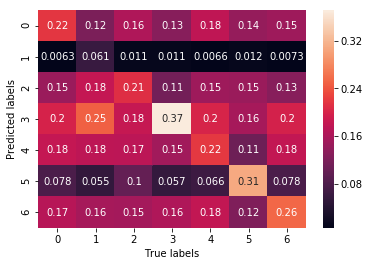

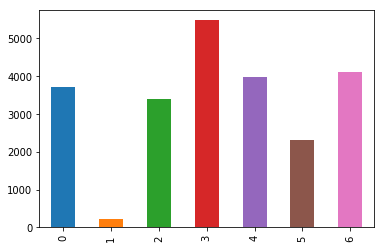

Accuracy on training set : 0.807065858840192
Accuracy on testing set : 0.2702562775045302


In [54]:
clf_16=DecisionTreeClassifier(random_state=1,min_samples_split=13)
run_decision_tree(clf_16,X_train_16,y_train_16,X_test_16,y_test_16)

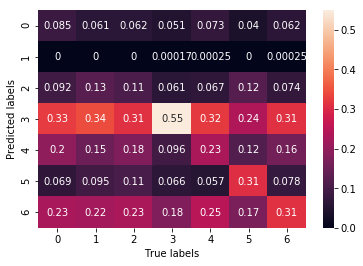

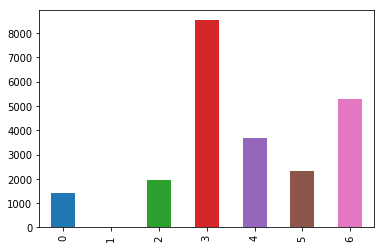

Accuracy on training set : 0.3794948461720041
Accuracy on testing set : 0.2931227888514971


In [55]:
clf_16=DecisionTreeClassifier(random_state=1,min_samples_split=13,max_depth=7)
run_decision_tree(clf_16,X_train_16,y_train_16,X_test_16,y_test_16)

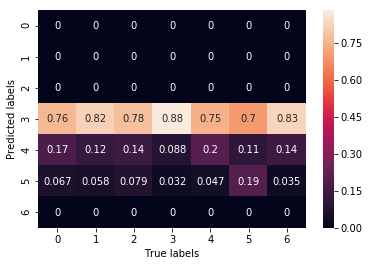

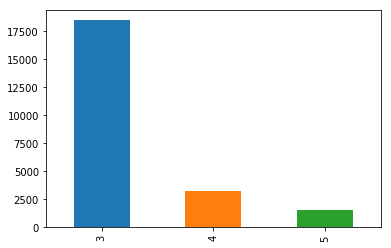

Accuracy on training set : 0.2787001337634747
Accuracy on testing set : 0.27776339632410046


In [56]:
clf_16=DecisionTreeClassifier(random_state=1,min_samples_split=100,max_depth=2)
run_decision_tree(clf_16,X_train_16,y_train_16,X_test_16,y_test_16)

## Running decision tree on happy dataset with different settings

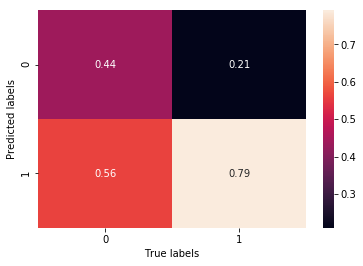

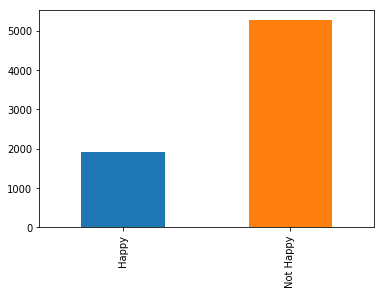

Accuracy on training set : 0.9998258385872026
Accuracy on testing set : 0.702842017275007


In [43]:
#Decision tree on binary classification happy dataset
clf_happy=DecisionTreeClassifier(random_state=1)
run_decision_tree(clf_happy,X_train_happy,y_train_happy,X_test_happy,y_test_happy)

In [38]:
#KFold cross validation accuracy results on happy training set with default Decision Tree
#Performing 10 Fold Cross Validation with 10 folds

clf_happy=DecisionTreeClassifier(random_state=1)
accuracy=cross_val_score(clf_happy,X_train_happy,y_train_happy,cv=10,scoring='accuracy')
print(accuracy)
print("Accuracy Using KFold Cross Validation is:",accuracy.mean())

[0.70856546 0.70926184 0.69603064 0.71518106 0.68617207 0.70348432
 0.69442509 0.7087108  0.70592334 0.71010453]
Accuracy Using KFold Cross Validation is: 0.703785914632059


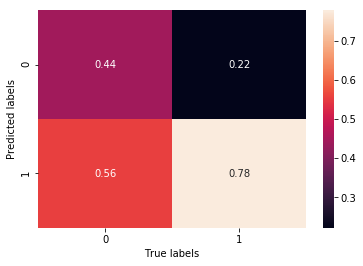

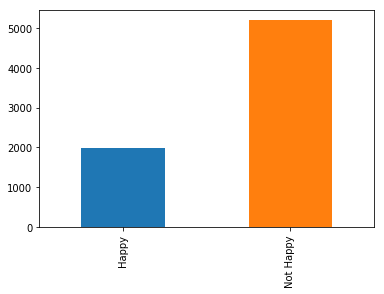

Accuracy on training set : 0.9717510188442648
Accuracy on testing set : 0.6954583449428811


In [44]:
#Experimenting with different parameters 
clf_happy=DecisionTreeClassifier(random_state=1,min_samples_split=13)
run_decision_tree(clf_happy,X_train_happy,y_train_happy,X_test_happy,y_test_happy)

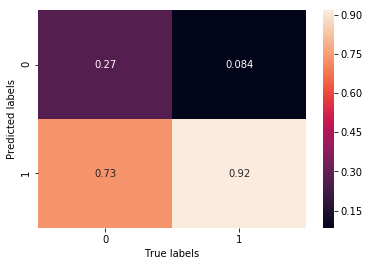

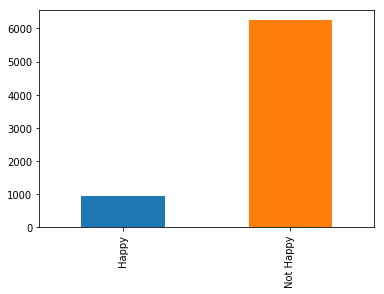

Accuracy on training set : 0.7887422062767773
Accuracy on testing set : 0.754806352744497


In [45]:
#Experimenting with different parameters 
clf_happy=DecisionTreeClassifier(random_state=1,min_samples_split=13,max_depth=7)
run_decision_tree(clf_happy,X_train_happy,y_train_happy,X_test_happy,y_test_happy)

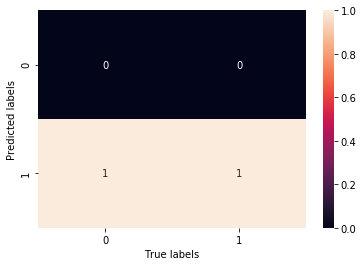

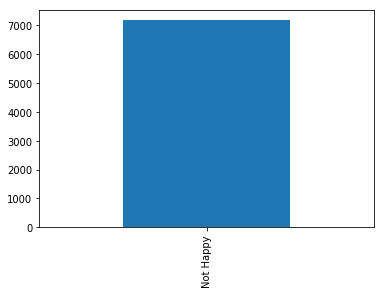

Accuracy on training set : 0.749068236441534
Accuracy on testing set : 0.7513234884368905


In [46]:
#Experimenting with different parameters 
clf_happy=DecisionTreeClassifier(random_state=1,min_samples_split=100,max_depth=2)
run_decision_tree(clf_happy,X_train_happy,y_train_happy,X_test_happy,y_test_happy)

## Moving 9000 rows from Happy dataset

In [11]:
#Moving 9000 rows from training to testing in happy datasets
pixel_cols=train_data_happy.columns.drop('emotion')
rows_9000=train_data_happy.iloc[:9000]
print(rows_9000.shape)
X_train_9th=train_data_happy.iloc[9000:][pixel_cols]
y_train_9th=train_data_happy.iloc[9000:]['emotion']
print(X_train_9th.shape)
new_test=pd.concat((test_data_happy,rows_9000),axis=0)
X_test_9th=new_test[pixel_cols]
y_test_9th=new_test['emotion']
print(X_test_9th.shape)

(9000, 2305)
(19709, 2304)
(16178, 2304)


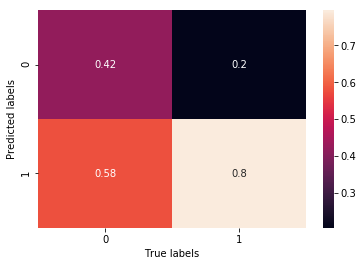

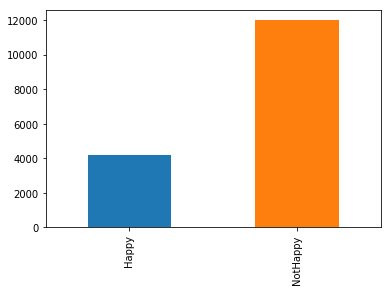

Accuracy on training set : 1.0
Accuracy on testing set : 0.7003955989615527


In [90]:
clf_9th=DecisionTreeClassifier(random_state=1)
run_decision_tree(clf_9th,X_train_9th,y_train_9th,X_test_9th,y_test_9th)

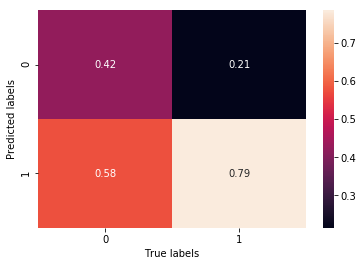

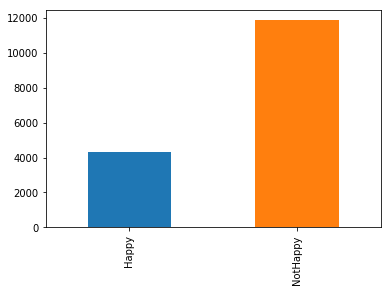

Accuracy on training set : 0.9704703434978944
Accuracy on testing set : 0.6942143651872914


In [91]:
clf_9th=DecisionTreeClassifier(random_state=1,min_samples_split=13)
run_decision_tree(clf_9th,X_train_9th,y_train_9th,X_test_9th,y_test_9th)

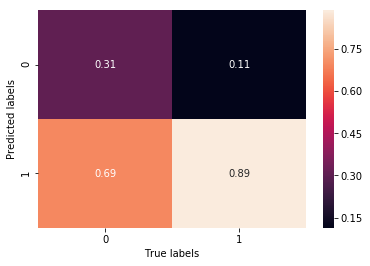

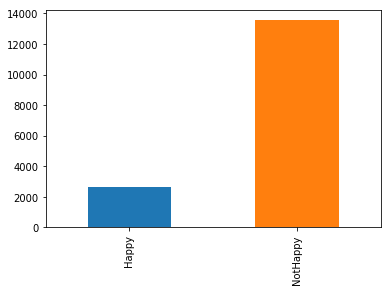

Accuracy on training set : 0.7983662286265159
Accuracy on testing set : 0.7391519347261714


In [92]:
clf_9th=DecisionTreeClassifier(random_state=1,min_samples_split=13,max_depth=7)
run_decision_tree(clf_9th,X_train_9th,y_train_9th,X_test_9th,y_test_9th)

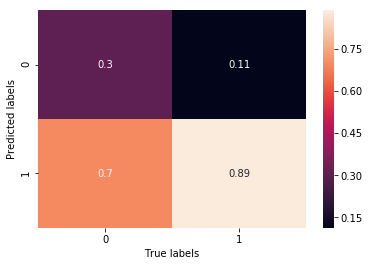

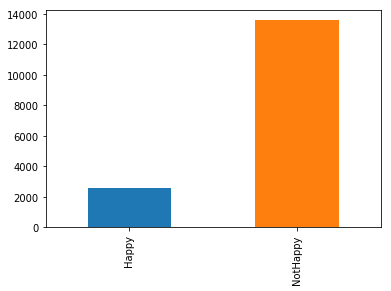

Accuracy on training set : 0.792785022071135
Accuracy on testing set : 0.7399554951168253


In [93]:
clf_9th=DecisionTreeClassifier(random_state=1,min_samples_split=100,max_depth=7)
run_decision_tree(clf_9th,X_train_9th,y_train_9th,X_test_9th,y_test_9th)

## Moving 16000 rows from Happy dataset

In [12]:
#Moving 16000 rows from training to testing
pixel_cols=train_data_happy.columns.drop('emotion')
rows_16000=train_data_happy.iloc[:16000]
print(rows_16000.shape)
X_train_16th=train_data_happy.iloc[16000:][pixel_cols]
y_train_16th=train_data_happy.iloc[16000:]['emotion']
print(X_train_16th.shape)
new_test=pd.concat((test_data_happy,rows_16000),axis=0)
X_test_16th=new_test[pixel_cols]
y_test_16th=new_test['emotion']
print(X_test_16th.shape)

(16000, 2305)
(12709, 2304)
(23178, 2304)


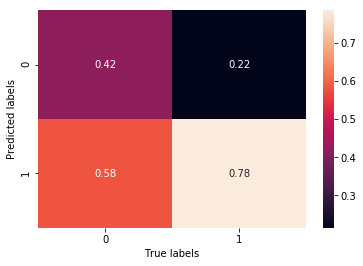

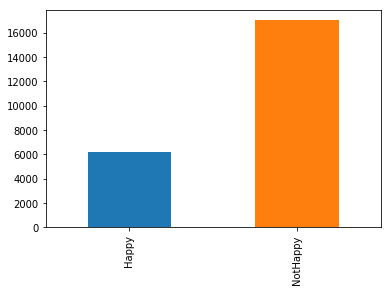

Accuracy on training set : 1.0
Accuracy on testing set : 0.6925964276469065


In [95]:
clf_16th=DecisionTreeClassifier(random_state=1)
run_decision_tree(clf_16th,X_train_16th,y_train_16th,X_test_16th,y_test_16th)

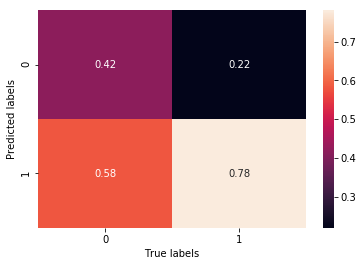

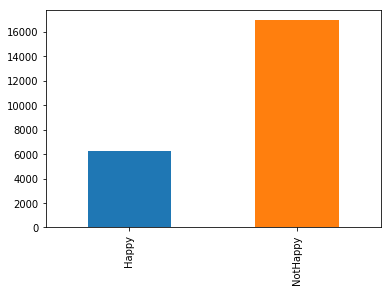

Accuracy on training set : 0.9689983476276655
Accuracy on testing set : 0.6894468892915696


In [96]:
clf_16th=DecisionTreeClassifier(random_state=1,min_samples_split=13)
run_decision_tree(clf_16th,X_train_16th,y_train_16th,X_test_16th,y_test_16th)

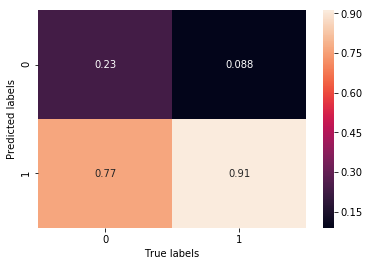

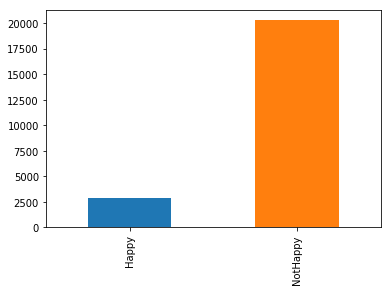

Accuracy on training set : 0.7980958375954048
Accuracy on testing set : 0.7408749676417292


In [97]:
clf_16th=DecisionTreeClassifier(random_state=1,min_samples_split=13,max_depth=7)
run_decision_tree(clf_16th,X_train_16th,y_train_16th,X_test_16th,y_test_16th)

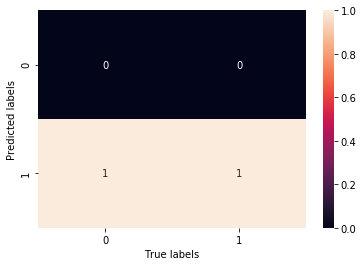

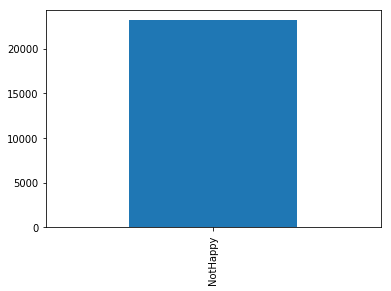

Accuracy on training set : 0.7517507278306712
Accuracy on testing set : 0.7482957977392355


In [98]:
clf_16th=DecisionTreeClassifier(random_state=1,min_samples_split=100,max_depth=2)
run_decision_tree(clf_16th,X_train_16th,y_train_16th,X_test_16th,y_test_16th)

## Visualizing decision tree

In [102]:
corr_coef_data=np.abs(final_data_train.corr()['emotion']).sort_values(ascending=False).head(11)
top_ten_data=corr_coef_data[1:11].index.tolist()

In [10]:
print(top_ten_data)

['p1457', 'p1505', 'p1409', 'p1504', 'p1552', 'p1456', 'p1553', 'p1361', 'p1410', 'p1362']


In [9]:
top_ten_data=['p1457',
 'p1505',
 'p1409',
 'p1504',
 'p1552',
 'p1456',
 'p1553',
 'p1361',
 'p1410',
 'p1362']

In [11]:
X_train_10=final_data_train.loc[:,top_ten_data]
y_train_10=final_data_train['emotion']
X_test_10=test_data.loc[:,top_ten_data]
y_test_10=test_data['emotion']

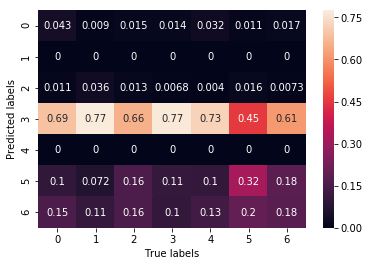

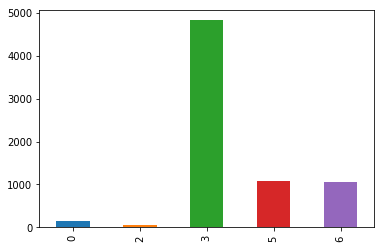

Accuracy on training set : 0.2611376223483925
Accuracy on testing set : 0.26469768737809973


In [27]:
clf_top10=DecisionTreeClassifier(random_state=1,max_depth=3,min_samples_split=100)
run_decision_tree(clf_top10,X_train_10,y_train_10,X_test_10,y_test_10)

In [28]:
dot_data = tree.export_graphviz(clf_top10, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("X_train_10") 

'X_train_10.pdf'

## View of Decision Tree with only ten features

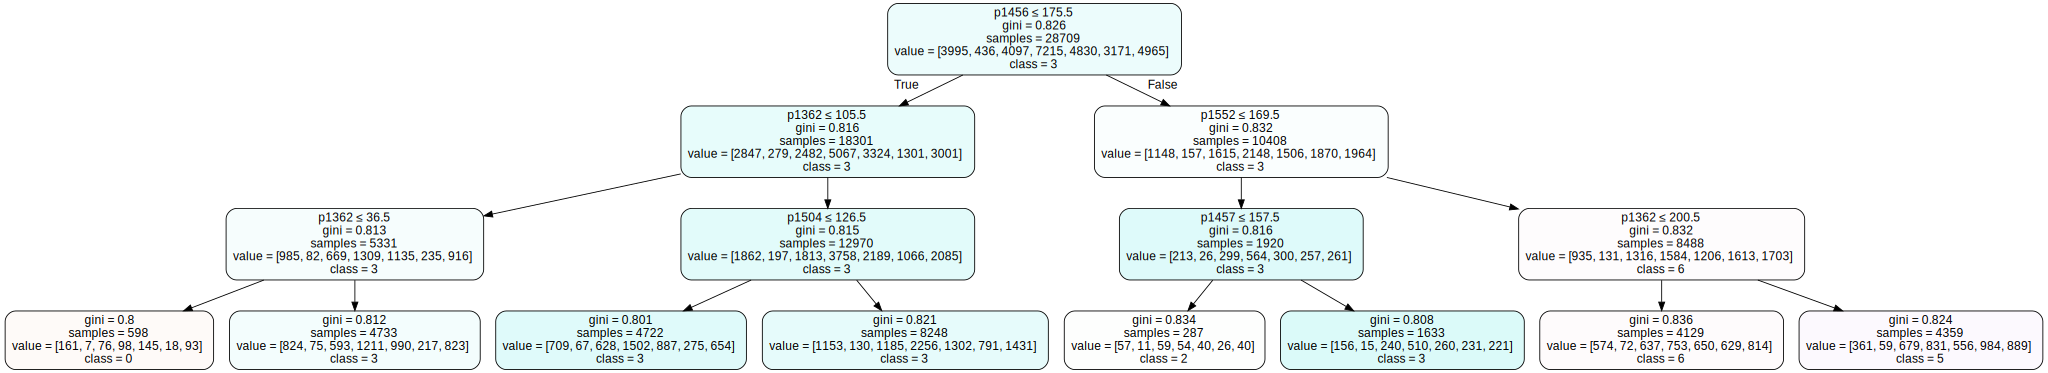

In [29]:
dot_data = tree.export_graphviz(clf_top10, out_file=None, feature_names=top_ten_data,  class_names='0123456',  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [31]:
clf_top10

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

## Random Forest on multiclass dataset

In [42]:
# With Cross Validation
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=2)
accuracy=cross_val_score(clf,X_train,y_train,cv=10,scoring='accuracy')
print("Accuracy Using KFold Cross Validation is:",accuracy.mean())

Accuracy Using KFold Cross Validation is: 0.4025581475066632


In [13]:
def run_random_forest(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    train_predictions=clf.predict(X_train)
    test_predictions=clf.predict(X_test)
    train_accuracy=accuracy_score(y_train,train_predictions)
    test_accuracy=accuracy_score(y_test,test_predictions)
    c_matrix=confusion_matrix(test_predictions,y_test)
    ax=plt.subplot()
    cm=pd.DataFrame(c_matrix)
    
    #Finding the relative percent of actual vs prediction
    row_sum=cm.sum(axis=0)
    cm=cm.apply(lambda x:x/row_sum,axis=1)
    sns.heatmap(cm,annot=True,ax=ax)
    ax.set_xlabel('True labels')
    ax.set_ylabel('Predicted labels')
    plt.show()
    test_predictions=pd.DataFrame(test_predictions)
    test_predictions[0].value_counts().sort_index().plot.bar()
    plt.show()
    print("Accuracy on training set :",train_accuracy)
    print("Accuracy on testing set :",test_accuracy)
    
    

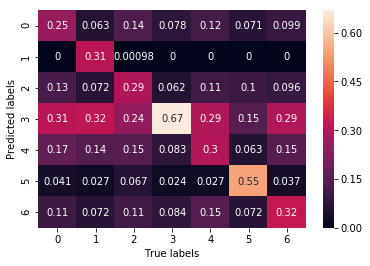

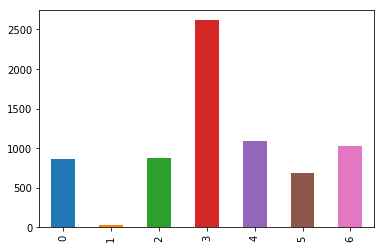

Accuracy on training set : 0.9982235535894667
Accuracy on testing set : 0.4155753691836166


In [43]:
clf=RandomForestClassifier(n_estimators=20,random_state=1)
run_random_forest(clf,X_train,y_train,X_test,y_test)

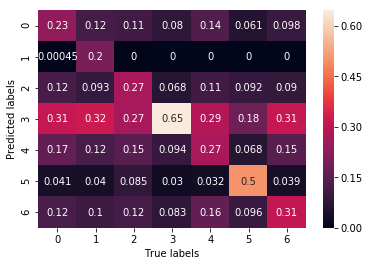

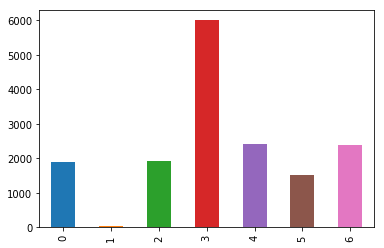

Accuracy on training set : 0.9982748997919733
Accuracy on testing set : 0.3899740388181481


In [55]:
clf=RandomForestClassifier(n_estimators=20,random_state=1)
run_random_forest(clf,X_train_9,y_train_9,X_test_9,y_test_9)

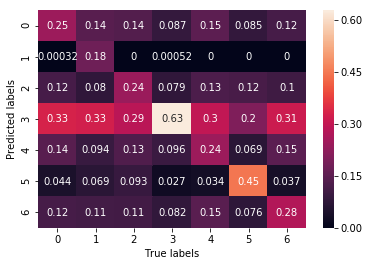

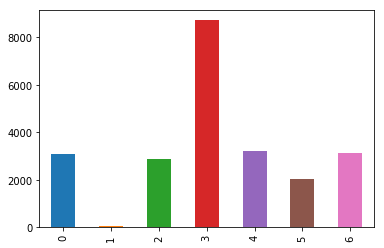

Accuracy on training set : 0.9988984184436226
Accuracy on testing set : 0.3666839244110795


In [56]:
clf=RandomForestClassifier(n_estimators=20,random_state=1)
run_random_forest(clf,X_train_16,y_train_16,X_test_16,y_test_16)

## Lets tweak the parameters

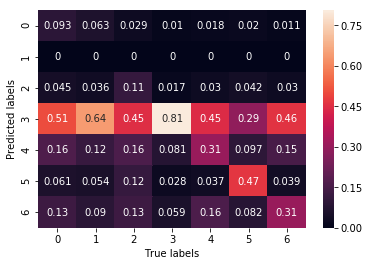

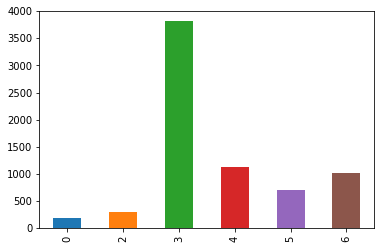

Accuracy on training set : 0.5004354035319935
Accuracy on testing set : 0.3879910838673725


In [44]:
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=100,max_depth=10)
run_random_forest(clf,X_train,y_train,X_test,y_test)

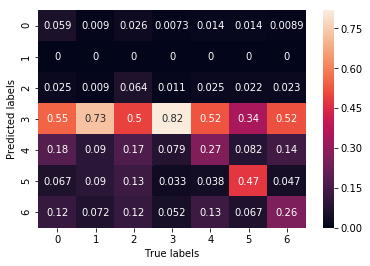

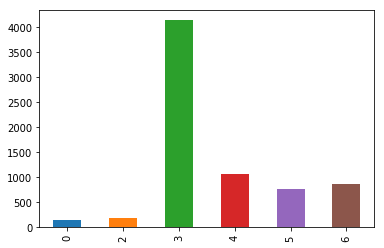

Accuracy on training set : 0.43944407677035074
Accuracy on testing set : 0.3654221231540819


In [54]:
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=100,max_depth=8)
run_random_forest(clf,X_train,y_train,X_test,y_test)

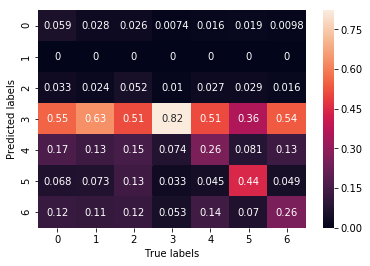

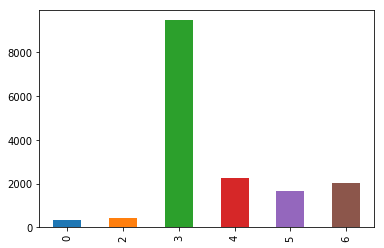

Accuracy on training set : 0.4500989395707545
Accuracy on testing set : 0.35888243293361355


In [50]:
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=100,max_depth=8)
run_random_forest(clf,X_train_9,y_train_9,X_test_9,y_test_9)

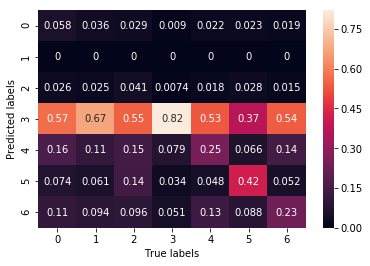

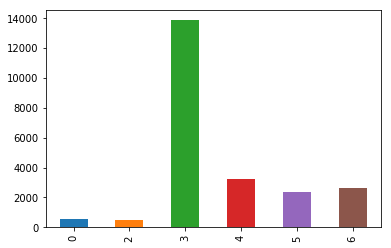

Accuracy on training set : 0.4584939806436384
Accuracy on testing set : 0.34744153939080163


In [51]:
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=100,max_depth=8)
run_random_forest(clf,X_train_16,y_train_16,X_test_16,y_test_16)

## Random Forest on Happy Dataset

In [45]:
# With Cross Validation
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=2)
accuracy=cross_val_score(clf,X_train_happy,y_train_happy,cv=10,scoring='accuracy')
print("Accuracy Using KFold Cross Validation is:",accuracy.mean())

Accuracy Using KFold Cross Validation is: 0.7780833231772435


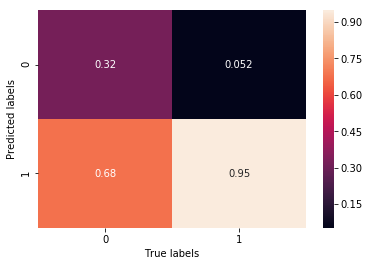

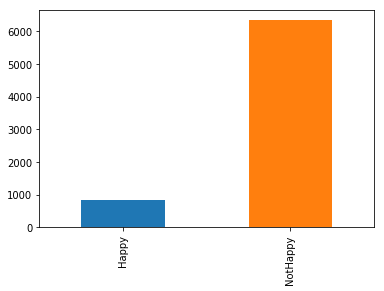

Accuracy on training set : 0.9987112055452994
Accuracy on testing set : 0.7932571747004736


In [46]:
clf=RandomForestClassifier(n_estimators=20,random_state=1)
run_random_forest(clf,X_train_happy,y_train_happy,X_test_happy,y_test_happy)

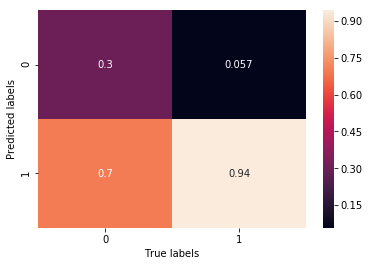

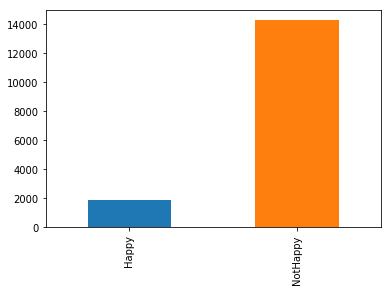

Accuracy on training set : 0.9983763762747984
Accuracy on testing set : 0.7820496971195451


In [47]:
clf=RandomForestClassifier(n_estimators=20,random_state=1)
run_random_forest(clf,X_train_9th,y_train_9th,X_test_9th,y_test_9th)

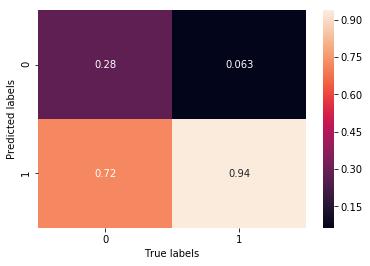

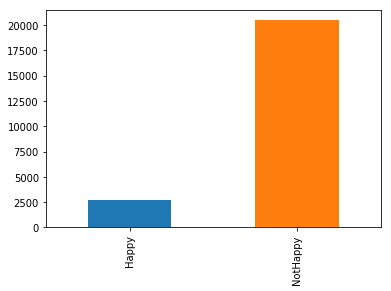

Accuracy on training set : 0.9989771028405068
Accuracy on testing set : 0.7728449391664509


In [41]:
clf=RandomForestClassifier(n_estimators=20,random_state=1)
run_random_forest(clf,X_train_16th,y_train_16th,X_test_16th,y_test_16th)

## Tweak Parameters

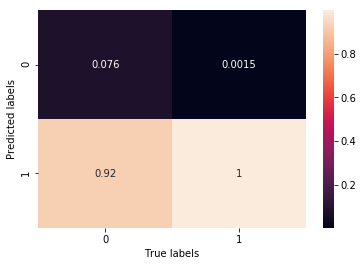

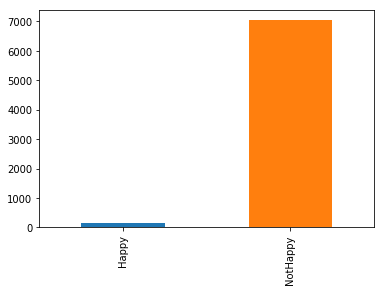

Accuracy on training set : 0.7734508342331673
Accuracy on testing set : 0.7705488994148788


In [53]:
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=100,max_depth=8)
run_random_forest(clf,X_train_happy,y_train_happy,X_test_happy,y_test_happy)

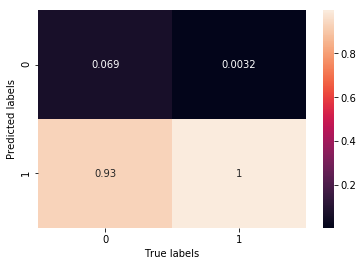

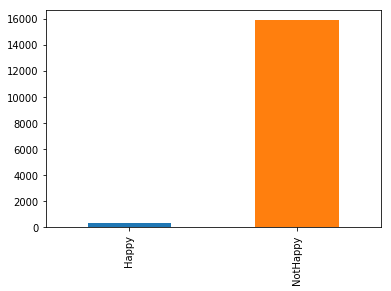

Accuracy on training set : 0.7757877111979299
Accuracy on testing set : 0.7641859315119298


In [48]:
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=100,max_depth=8)
run_random_forest(clf,X_train_9th,y_train_9th,X_test_9th,y_test_9th)

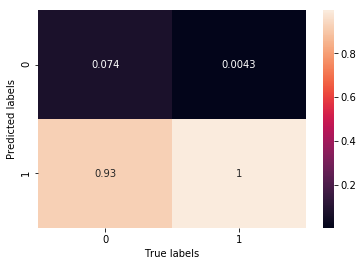

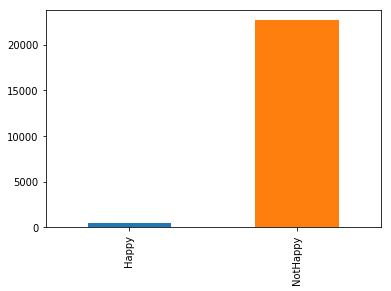

Accuracy on training set : 0.7811000078684397
Accuracy on testing set : 0.7660712744844249


In [49]:
clf=RandomForestClassifier(n_estimators=20,random_state=1,min_samples_split=100,max_depth=8)
run_random_forest(clf,X_train_16th,y_train_16th,X_test_16th,y_test_16th)

In [57]:
clf=RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)